# Fine Tuning 
## Training Set Prep

In [1]:
import os
import random
import json
import pathlib
import shutil
import tarfile
import boto3
import numpy as np
import pandas as pd
import tensorflow as tf

pd.set_option('display.max_columns', None)

In [2]:
from boto3.session import Session

def aws_connect(service, profile='default', session=False):
    # Connect to AWS with IAM Role
    sess = Session(profile_name=profile)

    try:
        resource = sess.resource(service)
        client = resource.meta.client

        if session:
            return resource, client, sess
        else:
            return resource, client
    except:
        client = sess.client(service)

        if session:
            return client, sess
        else:
            return client

In [3]:
_, s3, boto_sess = aws_connect('s3', 'lw2134', session=True)

In [11]:
# Cards
s3.download_file('magicml-clean-data.dev', 'cards/cards.csv', 'cardsS3.csv')

In [2]:
merge_cols = [
    'Names','id','mtgArenaId','scryfallId','name','colors','setName',
    'convertedManaCost','manaCost','loyalty','power','toughness',
    'type','types','subtypes','text','image_urls',
    'brawl','commander','duel','future','historic','legacy','modern',
    'oldschool','pauper','penny','pioneer','standard','vintage'
  ]

In [3]:
cards_df = pd.read_csv('cardsS3.csv')\
    .assign(Names=lambda df: df.name + '-' + df.id.astype('str'))\
    .assign(Names=lambda df: df.Names.apply(lambda x: x.replace(' ', '_').replace('//', 'II')))\
    .fillna('0')\
    [merge_cols]

#cards_txt = list(cards_df.text)
#cards_name = [
#    (name + '-' + str(id_val)).replace(' ','_').replace('//', 'II') for name, id_val in zip(cards_df.name, cards_df.id)
#]

print(cards_df.shape)
cards_df.head(2)

C:\Users\lwest\Anaconda3\envs\magicml\lib\site-packages\IPython\core\interactiveshell.py:3170: DtypeWarning: Columns (16,40) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(11573, 30)


,Names,id,mtgArenaId,scryfallId,name,colors,setName,convertedManaCost,manaCost,loyalty,power,toughness,type,types,subtypes,text,image_urls,brawl,commander,duel,future,historic,legacy,modern,oldschool,pauper,penny,pioneer,standard,vintage
0,"Galea,_Kindler_of_Hope-4751",4751,0,1efbea01-c6a1-4380-a14f-6206c7895e48,"Galea, Kindler of Hope","G,U,W",Forgotten Realms Commander,4.0,{1}{G}{W}{U},0,4,4,Legendary Creature — Elf Knight,Creature,"Elf,Knight",Vigilance\nYou may look at the top card of you...,{'small': 'https://c1.scryfall.com/file/scryfa...,Blank,Legal,Legal,Blank,Blank,Legal,Blank,Blank,Blank,Blank,Blank,Blank,Legal
1,"Prosper,_Tome-Bound-4752",4752,0,d743336e-d5c7-4053-a23d-92ec7581f74e,"Prosper, Tome-Bound","B,R",Forgotten Realms Commander,4.0,{2}{B}{R},0,1,4,Legendary Creature — Tiefling Warlock,Creature,"Tiefling,Warlock",Deathtouch\nMystic Arcanum — At the beginning ...,{'small': 'https://c1.scryfall.com/file/scryfa...,Blank,Legal,Legal,Blank,Blank,Legal,Blank,Blank,Blank,Blank,Blank,Blank,Legal


In [8]:
subtypes = [_ for _ in list(set('-'.join(train_df.subtypes.unique()).replace(',','-').split('-')))]
len(subtypes)

NameError: name 'train_df' is not defined

In [4]:
train_cols = ['colors','types','text']

In [5]:
cards_df[train_cols].sample(10)

,colors,types,text
4514,B,Sorcery,"You draw two cards, lose 2 life, and get {E}{E..."
2405,B,Sorcery,Return target creature card from your graveyar...
4565,R,Creature,Flying\n{R}: Skyship Stalker gets +1/+0 until ...
11313,R,Sorcery,Gain control of target creature until end of t...
5601,"G,R",Creature,{T}: Add {G} for each creature with power 4 or...
7971,U,Sorcery,You may pay {2}{U} rather than pay this spell'...
8764,G,Sorcery,"As an additional cost to cast this spell, reve..."
6104,G,Planeswalker,[+1]: Reveal the top four cards of your librar...
9114,W,Creature,Flying\nWhen Apothecary Geist enters the battl...
2985,U,Instant,Tap target creature. That creature perpetually...


In [5]:
train_df = cards_df[train_cols]\
    .assign(cls=lambda df: (df.colors + '-' + df.types).str.replace(',','_'))\
    [['cls','text']]

print(train_df.shape)

#print('Unique colors: {}'.format(train_df.colors.nunique()))
#print('Unique basic type: {}'.format(train_df.types.nunique()))
#print('Unique subtypes: {}'.format(train_df.subtypes.nunique()))
#print('Unique fulltype: {}'.format(train_df.type.nunique()))
print('Unique cls: {}'.format(train_df.cls.nunique()))
train_df.sample(20)

(11573, 2)
Unique cls: 158


,cls,text
10386,B-Creature,"When Lazotep Reaver enters the battlefield, am..."
10877,G_W-Creature,Each creature you control assigns combat damag...
9883,W-Enchantment,"When Sparring Regimen enters the battlefield, ..."
6565,0-Artifact_Creature,"Trample\nTraxos, Scourge of Kroog enters the b..."
2848,R-Sorcery,"As an additional cost to cast this spell, sacr..."
11451,0-Land,{T}: Add {U}.
2113,R_U-Creature,Flying\nWhenever you cast an instant or sorcer...
6820,W_R-Instant,Response deals 5 damage to target attacking or...
6327,W-Creature,Flash\nVigilance\nWhen Guardian of Faith enter...
5221,G-Creature,Flash\nOther Wolves and Werewolves you control...


<AxesSubplot:>

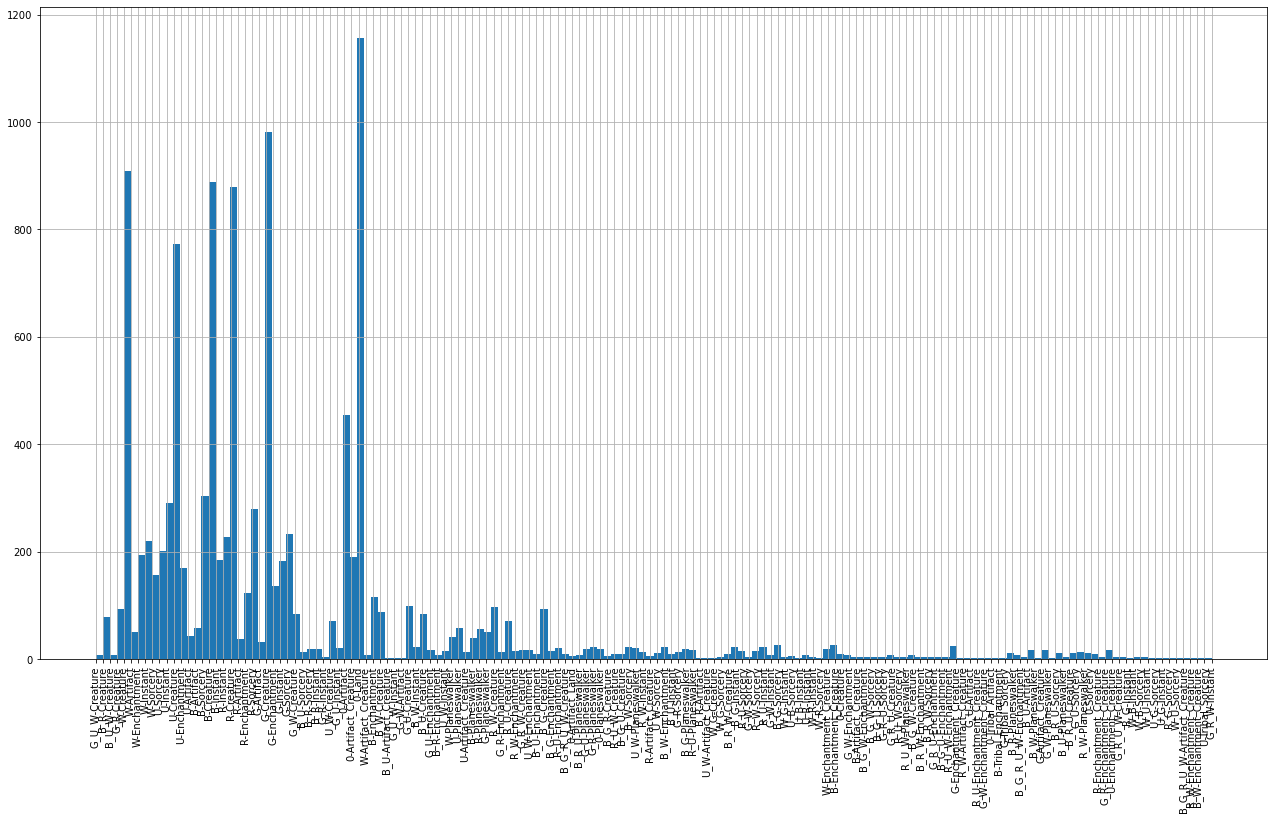

In [17]:
train_df.cls.hist(
    bins=train_df.cls.nunique(),
    figsize=(22,12),
    xrot=90
)

In [22]:
train_df\
  .groupby('cls', as_index=False)\
  .agg(cnt=('text','count'))\
  .sort_values('cnt', ascending=False)\
  .query('cnt < 5')

,cls,cnt
31,B_G_W-Sorcery,4
154,W_R-Instant,4
113,R_U_W-Sorcery,4
9,B-Artifact_Creature,4
27,B_G_U-Enchantment,4
69,G_R-Enchantment_Creature,4
112,R_U_W-Planeswalker,4
28,B_G_U-Sorcery,4
74,G_R_U-Enchantment,4
30,B_G_W-Enchantment,4


158
(55, 2)


<AxesSubplot:xlabel='cls'>

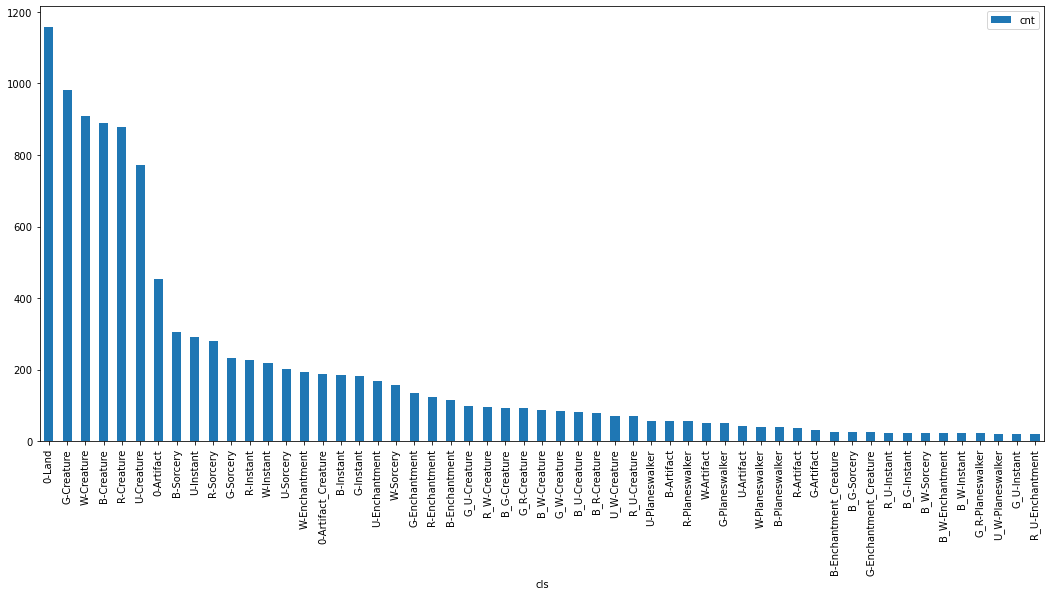

In [23]:
print(train_df.cls.nunique())

plot_df = train_df\
    .groupby('cls', as_index=False)\
    .agg(cnt=('text','count'))\
    .sort_values('cnt', ascending=False)\
    .query('cnt >= 20')

print(plot_df.shape)

plot_df\
    .plot.bar(
        x='cls',
        y='cnt',
        figsize=(18,8),
        rot=90
    )

In [114]:
pw = 'Planeswalker'

train_df\
    .groupby('cls', as_index=False)\
    .agg(cnt=('Names','count'))\
    .sort_values('cnt', ascending=False)\
    .query("`cls`.str.contains('Planeswalker')")

,cls,cnt
115,U - Planeswalker,47
89,R - Planeswalker,44
59,G - Planeswalker,39
135,W - Planeswalker,33
11,B - Planeswalker,28
4,0 - Planeswalker,18
16,"B,G - Planeswalker",18
127,"U,W - Planeswalker",17
81,"G,W - Planeswalker",16
97,"R,U - Planeswalker",16


In [56]:
for c in train_df.sample(5).text:
    print(c+'\n')

Each creature deals damage to itself equal to its power.

Choose one or both —
• Target creature gets -1/-1 until end of turn.
• Put a +1/+1 counter on target creature.

Whenever Selhoff Occultist or another creature dies, target player mills a card.

Target opponent reveals their hand. You choose a noncreature, nonland card from it. That player discards that card.

Whenever a creature you control attacks, it gets +1/+0 until end of turn for each other attacking creature that shares a creature type with it.



## Organize card text into folders by Class, like [HuggingFace example]('https://huggingface.co/transformers/custom_datasets.html')

In [6]:
cls_list = list(train_df.cls.unique())

In [25]:
train_df.head(3)

,cls,text
0,G_U_W-Creature,Vigilance\nYou may look at the top card of you...
1,B_R-Creature,Deathtouch\nMystic Arcanum — At the beginning ...
2,B_U_W-Creature,Whenever one or more creature cards are put in...


## Make cls directories

In [10]:
base_dir = '../data/fine_tune'
target_dir = '/cls'
cls_dir = pathlib.Path(base_dir + target_dir)

In [26]:
for c in train_df.cls.unique():
    (cls_dir/c).mkdir(parents=True, exist_ok=True)

## Build dataset as text file for each card text in class directories

In [27]:
for i, z in enumerate(zip(train_df.cls, train_df.text)):
    c, txt = z
    f = '{}_{}.txt'.format(i, c)
    (cls_dir/c/f).write_text(txt, encoding='utf-8')

## Handle single example classes by making a copy
This is so we can use train_test_split(stratify=train_labels)

In [75]:
all_data = cls_dir.glob('*')

all_data = [x for x in all_data]

all_cls = [x.name for x in all_data]
cls_cnt = [len(os.listdir(x)) for x in all_data]

single_cls = pd.DataFrame({'cls': all_cls, 'cnt': cls_cnt, 'path': all_data})\
  .query('cnt == 1')\
  .reset_index(drop=True)\
  .path

for cls in single_cls:
  for fname in os.listdir(cls):
    orig = (cls/fname)
    new = str(orig).replace('.txt', '_copy.txt')
    print(orig)
    print(new)

    shutil.copyfile(orig, new)

## Load Training Data

In [9]:
base_dir = '../data/fine_tune'
target_dir = '/cls'
cls_dir = pathlib.Path(base_dir + target_dir)

In [6]:
cls_list = list(train_df.cls.unique())[0:5]
cls_idx = {cls_list[idx]: idx for idx in range(len(cls_list))}

In [7]:
from pathlib import Path

def load_fine_tuning_data(target_dir, label_idx):
    #target_dir = Path(target_dir)
    texts = []
    labels = []
    for label_dir in label_idx.keys():
        for txt_file in (target_dir/label_dir).iterdir():
            texts.append(txt_file.read_text())
            labels.append(label_idx[label_dir])

    return texts, labels

In [10]:
train_texts, train_labels = load_fine_tuning_data(cls_dir, cls_idx)

## Split in Training and Validation  

### Have to handle fact that some classes only have 1 example!!!

In [10]:
# MAYBE SKIP???
from sklearn.model_selection import train_test_split

VAL_SIZE = 0.1

train_texts, val_texts, train_labels, val_labels = train_test_split(
  train_texts,
  train_labels,
  test_size=VAL_SIZE,
  stratify=train_labels
)

## Tokenize and Pad

In [121]:
#from transformers import GPT2TokenizerFast

#tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
#tokenizer.pad_token = tokenizer.eos_token

In [11]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [35]:
tokenizer.model_max_length

512

In [96]:
txt_lens = [len(x.split(' ')) for x in train_texts]
max(txt_lens)

86

In [12]:
train_encodings = tokenizer(train_texts, padding='max_length', max_length=150)
#val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [37]:
tokenizer.save_pretrained('tokenizer')

('tokenizer\\tokenizer_config.json',
 'tokenizer\\special_tokens_map.json',
 'tokenizer\\vocab.txt',
 'tokenizer\\added_tokens.json',
 'tokenizer\\tokenizer.json')

In [39]:
from transformers import BertTokenizer
tokenizer2 = BertTokenizer.from_pretrained('tokenizer')

In [40]:
train_encodings = tokenizer2(train_texts, padding='max_length', max_length=150)

## Convert to TFDataset

In [13]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))

#val_dataset = tf.data.Dataset.from_tensor_slices((
#    dict(val_encodings),
#    val_labels
#))

In [14]:
train_dataset.element_spec

({'input_ids': TensorSpec(shape=(150,), dtype=tf.int32, name=None),
  'token_type_ids': TensorSpec(shape=(150,), dtype=tf.int32, name=None),
  'attention_mask': TensorSpec(shape=(150,), dtype=tf.int32, name=None)},
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [19]:
input_size = train_dataset.element_spec[0]['input_ids'].shape[0]
input_size

150

In [18]:
train_dataset.element_spec[0].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

## Train

In [15]:
#print('N Val Labels: {}'.format(len(set(val_labels))))

n_labels = len(set(train_labels))
print('N Train Labels: {}'.format(n_labels))

N Train Labels: 5


In [16]:
from transformers import TFAutoModel, TFAutoModelForSequenceClassification

def build_model(input_size, embedding_size, n_labels):
  bert = TFAutoModel.from_pretrained("bert-base-cased")

  input_ids = tf.keras.layers.Input(shape=(input_size,), name='input_ids', dtype='int32')
  input_token_types = tf.keras.layers.Input(shape=(input_size,), name='token_type_ids', dtype='int32')
  input_masks = tf.keras.layers.Input(shape=(input_size,), name='attention_mask', dtype='int32')

  x = bert(input_ids, input_token_types, input_masks)[0]
  #x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=False))(x)
  x = tf.keras.layers.GlobalMaxPool1D()(x)
  #x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(embedding_size, activation='relu', name='embeddings')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(n_labels)(x)

  clf_model = tf.keras.Model(
    inputs=[input_ids, input_token_types, input_masks],
    outputs = x
  )
  print(clf_model.summary())

  return clf_model

In [17]:
EPOCHS = 1
BATCH_SIZE = 8
LEARNING_RATE = 5e-5
TB_DIR = 'tensorboard'
EMBEDDING_SIZE = 256

In [20]:
clf_model = build_model(input_size, EMBEDDING_SIZE, n_labels)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Model: "model"
__________________________________________________________________________________________________
Layer 

In [21]:
clf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.metrics.SparseCategoricalAccuracy(),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3)
    ],
)

In [22]:
clf_model.fit(
  train_dataset.shuffle(500).batch(BATCH_SIZE),
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  callbacks=[tf.keras.callbacks.TensorBoard(log_dir=TB_DIR)]
)

137/137 [==============================] - 527s 4s/step - loss: 0.5671 - sparse_categorical_accuracy: 0.8265 - sparse_top_k_categorical_accuracy: 0.9753


In [23]:
model = tf.keras.Model(
  inputs=clf_model.inputs,
  outputs = clf_model.get_layer('embeddings').output
)

In [26]:
model.save('../data/fine_tune' + '/MTG_BERT/1')

C:\Users\lwest\Anaconda3\envs\magicml\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ../data/fine_tune/MTG_BERT\assets


INFO:tensorflow:Assets written to: ../data/fine_tune/MTG_BERT\assets


In [30]:
with tarfile.open('model.tar.gz', "w:gz") as tar:
  tar.add('MTG_BERT/1', arcname=os.path.basename('MTG_BERT/1'))

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'MTG_BERT/1'

In [29]:
model_path = 'model.tar.gz'
print('Extracting model from path: {}'.format(model_path))
with tarfile.open(model_path) as tar:
    tar.extractall(path='.')

Extracting model from path: model.tar.gz


In [4]:
import tensorflow as tf

In [7]:
model = tf.saved_model.load('MTG_BERT')

AttributeError: module 'tensorflow' has no attribute 'load'

In [24]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 150)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 token_type_ids[0][0]       

In [41]:
train_texts[0]

'Vigilance\nYou may look at the top card of your library any time.\nYou may cast Aura and Equipment spells from the top of your library. When you cast an Equipment spell this way, it gains "When this Equipment enters the battlefield, attach it to target creature you control."'

In [42]:
train_encoding = tokenizer([train_texts[0]], padding='max_length', max_length=input_size, return_tensors="tf")
train_encoding

{'input_ids': <tf.Tensor: shape=(1, 150), dtype=int32, numpy=
array([[  101,   159, 24874, 13831,  1192,  1336,  1440,  1120,  1103,
         1499,  3621,  1104,  1240,  3340,  1251,  1159,   119,  1192,
         1336,  2641, 27758,  1611,  1105, 22897, 12168,  1121,  1103,
         1499,  1104,  1240,  3340,   119,  1332,  1128,  2641,  1126,
        22897,  5814,  1142,  1236,   117,  1122, 12535,   107,  1332,
         1142, 22897,  7603,  1103, 13777,   117, 25337,  1122,  1106,
         4010,  6093,  1128,  1654,   119,   107,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0, 

In [197]:
cls_idx

{'G_U_W-Creature': 0,
 'B_R-Creature': 1,
 'B_U_W-Creature': 2,
 'G_R-Creature': 3,
 'W-Creature': 4,
 'W-Artifact': 5,
 'W-Enchantment': 6,
 'W-Instant': 7,
 'W-Sorcery': 8,
 'U-Sorcery': 9}

In [88]:
cards_df = pd.read_csv('cardsS3.csv')\
  .reset_index(drop=True)\
  .fillna(value={'text': 'Blank'})

cards_txt = list(cards_df.text)
cards_name = [
  (name + '-' + str(id_val)).replace(' ','_').replace('//', 'II') for name, id_val in zip(cards_df.name, cards_df.id)
]

C:\Users\lwest\Anaconda3\envs\magicml\lib\site-packages\IPython\core\interactiveshell.py:3170: DtypeWarning: Columns (16,40) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [93]:
cards_df[['id','name','text']].query('name == "Galea, Kindler of Hope"')

,id,name,text
0,4751,"Galea, Kindler of Hope",Vigilance\nYou may look at the top card of you...
317,5068,"Galea, Kindler of Hope",Vigilance\nYou may look at the top card of you...
6249,38613,"Galea, Kindler of Hope",Vigilance\nYou may look at the top card of you...


In [96]:
cards_name[0]

'Galea,_Kindler_of_Hope-4751'

In [102]:
card_txt_tokens = tokenizer(cards_txt[0], padding='max_length', max_length=150, return_tensors="tf")

In [78]:
card_txt_dict = dict(card_txt_tokens)

In [64]:
dataset = tf.data.Dataset.from_tensor_slices(
  (
    card_txt_tokens['input_ids'],
    card_txt_tokens['attention_mask'],
    card_txt_tokens['token_type_ids']
  )
)

In [104]:
embeddings = model(card_txt_tokens).numpy()
embeddings

array([[0.18505481, 0.        , 0.        , 0.31084839, 0.01312786,
        1.7267336 , 0.        , 1.5446678 , 1.2115915 , 0.01066004,
        0.        , 0.08734453, 1.3058707 , 0.3747535 , 0.56253886,
        0.        , 0.        , 0.07887223, 0.9496337 , 0.        ,
        0.        , 0.499754  , 0.        , 0.        , 0.        ,
        0.27918723, 0.        , 0.        , 0.6546898 , 0.        ,
        0.        , 0.        , 1.2017705 , 0.23167899, 0.        ,
        0.        , 0.06714673, 0.34785616, 0.        , 0.        ,
        0.        , 0.13531509, 0.07539111, 0.        , 0.        ,
        0.        , 0.1331367 , 0.13081346, 0.35393903, 0.        ,
        0.        , 0.4866598 , 0.12385809, 0.24384585, 0.21753202,
        0.04542874, 0.27403876, 0.8679435 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.710202  , 0.41947675, 0.        ,
        0.        , 2.1103027 , 1.6261171 , 0.61

In [79]:
embeddings = model.predict(card_txt_dict, batch_size=16)
embeddings

array([[0.        , 0.        , 0.        , ..., 0.871775  , 0.94399315,
        1.9702947 ],
       [0.        , 0.06747285, 0.        , ..., 0.6576043 , 0.93173593,
        2.0974448 ],
       [0.        , 0.        , 0.        , ..., 0.04658925, 1.4165938 ,
        1.3852215 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.41024607, 1.6178983 ,
        0.2184243 ],
       [0.        , 0.3357432 , 0.        , ..., 0.49335334, 1.5099057 ,
        1.5953767 ],
       [0.        , 0.        , 0.        , ..., 1.0342784 , 2.0395985 ,
        0.5400371 ]], dtype=float32)

In [81]:
corr = np.inner(embeddings, embeddings)

In [87]:
'Galea,_Kindler_of_Hope-4751' in cards_name[0:1000]

True

In [101]:
pd.DataFrame(corr, columns=cards_name[0:1000], index=cards_name[0:1000]).loc['Galea,_Kindler_of_Hope-4751', 'Galea,_Kindler_of_Hope-4751']

148.44072

In [100]:
pd.DataFrame(corr, columns=cards_name[0:1000], index=cards_name[0:1000])\
  [['Galea,_Kindler_of_Hope-4751']]\
  .sort_values(by='Galea,_Kindler_of_Hope-4751', ascending=False)

,"Galea,_Kindler_of_Hope-4751"
Oketra_the_True-5832,189.835449
Grand_Master_of_Flowers-5099,182.591049
Grand_Master_of_Flowers-5364,182.590988
Aven_Wind_Guide-6038,177.246506
Majestic_Myriarch-6008,176.364075
...,...
Steadfast_Paladin-5120,101.102097
Ramunap_Excavator-6020,100.779015
Pouncing_Cheetah-6016,100.012436
Cut_II_Ribbons-6043,99.611000


In [206]:
res = clf_model(train_encoding)
print(res)
print(tf.nn.softmax(res, axis=-1))
np.argmax(tf.nn.softmax(res, axis=-1).numpy())

tf.Tensor(
[[-1.4388261  -0.79059803 -1.6125364  -0.3912301   1.1768957  -0.61361474
   0.40323156  0.593866    0.736947    1.2922086 ]], shape=(1, 10), dtype=float32)
tf.Tensor(
[[0.01648402 0.03151992 0.01385549 0.04699248 0.2254534  0.03762253
  0.10400607 0.12584913 0.14520766 0.25300932]], shape=(1, 10), dtype=float32)


9

In [209]:
model = tf.keras.Model(
  inputs=clf_model.inputs,
  outputs = clf_model.get_layer('embeddings').output
)

In [213]:
res = model(train_encoding)
res.numpy()

array([[0.1623031 , 0.        , 0.7343738 , 0.40971297, 0.35925984,
        0.        , 0.        , 0.        , 0.        , 0.06207182,
        0.        , 0.        , 0.06542838, 0.19620104, 0.        ,
        0.4549396 , 0.11906414, 0.35826373, 0.        , 0.32381967,
        0.        , 0.        , 0.        , 0.        , 0.78335834,
        0.4621384 , 0.        , 0.        , 0.        , 0.        ,
        0.7057188 , 0.        , 0.        , 0.12593283, 0.        ,
        0.        , 1.0365506 , 0.03457262, 0.18150075, 0.        ,
        0.08478717, 0.        , 0.        , 0.43191472, 0.        ,
        0.        , 0.        , 0.8382378 , 0.0845039 , 0.71750885,
        0.59217596, 0.        , 0.        , 0.        , 0.        ,
        0.7069869 , 0.        , 0.        , 0.        , 0.90636104,
        0.        , 0.        , 0.9120938 , 0.22369602, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.15908827,
        0.        , 0.        , 0.        , 0.  

***

In [1]:
import pandas as pd

In [4]:
supported_sets = [
  'Forgotten Realms',
  'Strixhaven',
  'Throne of Eldraine',
  'Theros Beyond Death',
  'Ikoria: Lair of Behemoths',
  'Core Set 2021',
  'Zendikar Rising',
  'Kaldheim',
  'Core Set 2020',
  'War of the Spark',
  'Ravnica Allegiance',
  'Guilds of Ravnica',
  'Ixalan',
  'Rivals of Ixalan',
  'Dominaria',
  'Core Set 2019',
  'Historic Anthology',
  'Historic Anthology 2',
  'Historic Anthology 3',
  'Jumpstart',
  'Amonkhet Remastered',
  'Kaladesh Remastered'
]

In [5]:
LOCAL_RAW_PATH = '../data/mtgjson'

In [7]:
def get_image_uris(row):
  try:
      if pd.notna(row['image_uris']):
          return row['image_uris']
      else:
          return [card['image_uris'] for card in row['card_faces']]
  except:
      return 'Blank'

In [8]:
# Prep data
# Get MTGJSON data
cards_df = pd.read_csv(LOCAL_RAW_PATH + '/cards.csv')\
  .drop(columns=['index'])

# Merge with sets data
sets_df = pd.read_csv(LOCAL_RAW_PATH + '/sets.csv')[['code','name']]\
  .rename(columns={'name': 'setName', 'code':'setCode'})

cards_df = cards_df\
  .merge(sets_df, how='left', on='setCode')

# Merge with legalities / formats data
legs_df = pd.read_csv(LOCAL_RAW_PATH + '/legalities.csv')\
  .drop_duplicates(subset=['uuid','format','status'])\
  .pivot(index='uuid', columns='format', values='status')\
  .reset_index()\
  .fillna('Blank')

cards_df = cards_df\
  .merge(legs_df, how='left', on='uuid')

# Merge with scryfall data
scryfall_df = pd.read_json(LOCAL_RAW_PATH + '/scryfall_cards.json')
scryfall_sets = scryfall_df.set_name.unique()
supported_sets_varients = [scry_s for scry_s in scryfall_sets if any([s in scry_s for s in supported_sets])]

scryfall_df = scryfall_df\
    .query('set_name == @supported_sets_varients')\
    [['id','image_uris','card_faces']]\
    .reset_index(drop=True)\
    .assign(image_urls=lambda df: df.apply(get_image_uris, axis=1))\
    .drop(columns=['image_uris','card_faces'])\
    .rename(columns={'id': 'scryfallId'})

cards_df = cards_df\
  .merge(scryfall_df, how='left', on='scryfallId')

C:\Users\lwest\Anaconda3\envs\magicml\lib\site-packages\IPython\core\interactiveshell.py:3170: DtypeWarning: Columns (3,12,16,19,40,51) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
print(cards_df.shape)
cards_df.head(5)

(61998, 93)


,id,artist,asciiName,availability,borderColor,cardKingdomFoilId,cardKingdomId,colorIdentity,colorIndicator,colors,...,modern,oldschool,pauper,paupercommander,penny,pioneer,premodern,standard,vintage,image_urls
0,1,Pete Venters,NaN,"mtgo,paper",black,NaN,122719.0,W,NaN,W,...,Legal,Blank,Blank,Restricted,Legal,Blank,Legal,Blank,Legal,NaN
1,2,Volkan Baǵa,NaN,"mtgo,paper",black,NaN,122720.0,W,NaN,W,...,Legal,Blank,Legal,Legal,Legal,Blank,Legal,Blank,Legal,NaN
2,3,Justin Sweet,NaN,"mtgo,paper",black,NaN,122725.0,W,NaN,W,...,Legal,Blank,Legal,Legal,Legal,Blank,Legal,Blank,Legal,NaN
3,4,Matthew D. Wilson,NaN,"mtgo,paper",black,123094.0,122726.0,W,NaN,W,...,Legal,Blank,Blank,Restricted,Legal,Blank,Legal,Blank,Legal,NaN
4,5,Rebecca Guay,NaN,"mtgo,paper",black,123095.0,122727.0,W,NaN,W,...,Legal,Blank,Legal,Legal,Legal,Blank,Legal,Blank,Legal,NaN


In [1]:
import pandas as pd

In [2]:
embed_df = pd.read_parquet('../data/cards_embeddings.parquet')
print(embed_df.shape)
embed_df.head(5)

(10373, 10373)


,"Galea,_Kindler_of_Hope-4751","Prosper,_Tome-Bound-4752",Sefris_of_the_Hidden_Ways-4753,"Vrondiss,_Rage_of_Ancients-4754",Fey_Steed-4755,Holy_Avenger-4756,Immovable_Rod-4757,Mantle_of_the_Ancients-4758,Radiant_Solar-4759,Revivify-4760,...,Swamp-61989,Mountain-61990,Forest-61991,"Orah,_Skyclave_Hierophant-61992","Charix,_the_Raging_Isle-61993",Into_the_Roil-61994,Bloodchief's_Thirst-61995,Roil_Eruption-61996,Roiling_Regrowth-61997,Kargan_Warleader-61998
"Galea,_Kindler_of_Hope-4751",1.000000,0.561341,0.629551,0.576591,0.672578,0.635352,0.513502,0.731142,0.529273,0.577024,...,0.015822,0.000856,0.016533,0.575165,0.555767,0.592809,0.572976,0.479776,0.533010,0.380926
"Prosper,_Tome-Bound-4752",0.561341,1.000000,0.564873,0.521453,0.551346,0.427444,0.463979,0.580434,0.561041,0.501172,...,0.068526,0.033384,0.044551,0.541683,0.533398,0.528526,0.502451,0.398537,0.537174,0.296284
Sefris_of_the_Hidden_Ways-4753,0.629551,0.564873,1.000000,0.554480,0.638599,0.494233,0.455184,0.680465,0.611876,0.645469,...,0.020438,0.030995,0.029236,0.558692,0.478554,0.500377,0.465825,0.414055,0.493432,0.361058
"Vrondiss,_Rage_of_Ancients-4754",0.576591,0.521453,0.554480,1.000000,0.582828,0.546531,0.414580,0.694726,0.537554,0.612475,...,0.072991,0.110146,0.106410,0.525995,0.482405,0.549149,0.536154,0.547571,0.508484,0.440132
Fey_Steed-4755,0.672578,0.551346,0.638599,0.582828,1.000000,0.586323,0.561870,0.679132,0.533896,0.493466,...,0.005874,-0.020226,-0.015497,0.592051,0.575023,0.602637,0.605733,0.468395,0.465949,0.516642


In [11]:
card = 'Audacious_Thief-AJMP'

In [12]:
[c for c in embed_df.columns if 'Audacious_Thief' in c]

['Audacious_Thief-5491', 'Audacious_Thief-31377']

In [10]:
embed_df.reset_index()\
  .rename(columns={'index': 'Names'})\
  [['Names', card]]

KeyError: "['Audacious_Thief-AJMP'] not in index"

In [12]:
LOCAL_CLEAN_PATH = '../'

In [13]:
# Save cards for NLP in local EFS
cards_df\
  .query('setName == @supported_sets_varients')\
  .to_csv(LOCAL_CLEAN_PATH + '/cards.csv', index=False)

# Save ALL cards in local EFS
cards_df\
  .to_csv(LOCAL_CLEAN_PATH + '/all_cards.csv', index=False)

In [30]:
# Test Free Text Query
query = 'extra_turn'
embed_query = use_embed([query])
print(embed_query.shape)

(1, 512)


In [13]:
sim = np.inner(all_embeds, embed_query)
print(sim.shape)

(7998, 1)


In [31]:
sims_list = pd.DataFrame(sim, columns=['free_text_query'], index=cards_name)\
    .sort_values(by='free_text_query', ascending=False)\
    .head(50)\
    .reset_index()\
    .rename(columns={'index':'Names', 'free_text_query':'similarity'})\
    .merge(cards_df, how='left', on='Names')\
    .assign(similarity=lambda df: df.similarity.astype('str'))\
    .assign(id=lambda df: df.id.astype('str'))\
    .assign(mtgArenaId=lambda df: df.mtgArenaId.astype('str'))\
    .assign(loyalty=lambda df: df.loyalty.astype('str'))\
    .assign(power=lambda df: df.power.astype('str'))\
    .assign(toughness=lambda df: df.toughness.astype('str'))\
    .assign(convertedManaCost=lambda df: df.convertedManaCost.astype('str'))\
    .to_dict(orient='records')

sims_list[0]

{'Names': 'Time_Warp-17722',
 'similarity': '0.44100022',
 'id': '17722',
 'mtgArenaId': '0',
 'scryfallId': '87fe8637-9be1-4b57-832f-38cf92d23482',
 'name': 'Time Warp',
 'colors': 'U',
 'setName': 'Explorers of Ixalan',
 'convertedManaCost': '5.0',
 'manaCost': '{3}{U}{U}',
 'loyalty': '0',
 'power': '0',
 'toughness': '0',
 'type': 'Sorcery',
 'types': 'Sorcery',
 'subtypes': '0',
 'text': 'Target player takes an extra turn after this one.',
 'image_urls': "{'small': 'https://c1.scryfall.com/file/scryfall-cards/small/front/8/7/87fe8637-9be1-4b57-832f-38cf92d23482.jpg?1562927104', 'normal': 'https://c1.scryfall.com/file/scryfall-cards/normal/front/8/7/87fe8637-9be1-4b57-832f-38cf92d23482.jpg?1562927104', 'large': 'https://c1.scryfall.com/file/scryfall-cards/large/front/8/7/87fe8637-9be1-4b57-832f-38cf92d23482.jpg?1562927104', 'png': 'https://c1.scryfall.com/file/scryfall-cards/png/front/8/7/87fe8637-9be1-4b57-832f-38cf92d23482.png?1562927104', 'art_crop': 'https://c1.scryfall.com/fil

In [32]:
Item = {
    'freeText': query,
    'similarities': sims_list
}

In [11]:
merge_cols = [
    'Names','id','mtgArenaId','scryfallId','name','colors','setName',
    'convertedManaCost','manaCost','loyalty','power','toughness',
    'type','types','subtypes','text','image_urls',
    'brawl','commander','duel','future','historic','legacy','modern',
    'oldschool','pauper','penny','pioneer','standard','vintage'
]

cards_df = pd.read_csv('cards.csv')\
    .query('mtgArenaId.notnull()')\
    .assign(Names=lambda df: df.name + '-' + df.id.astype('str'))\
    .assign(Names=lambda df: df.Names.apply(lambda x: x.replace(' ', '_').replace('//', 'II')))\
    .fillna('0')\
    [merge_cols]

print(cards_df.shape)
cards_df.head(2)

(5419, 30)


,Names,id,mtgArenaId,scryfallId,name,colors,setName,convertedManaCost,manaCost,loyalty,...,future,historic,legacy,modern,oldschool,pauper,penny,pioneer,standard,vintage
4753,Archon_of_Sun's_Grace-4754,4754,74983.0,94f05268-0d4f-4638-aec3-a85fc339e3a7,Archon of Sun's Grace,W,Jumpstart Arena Exclusives,4.0,{2}{W}{W},0,...,Legal,Legal,Legal,Legal,Blank,Blank,Blank,Legal,Legal,Legal
4754,Audacious_Thief-4755,4755,74991.0,ba315deb-d5a9-4013-b6ef-e4efe652e569,Audacious Thief,B,Jumpstart Arena Exclusives,3.0,{2}{B},0,...,Blank,Legal,Legal,Legal,Blank,Legal,Blank,Legal,Blank,Legal


In [29]:
embed_df.columns.nunique()

5420

In [30]:
cards_df.query('Names == "Zof_Consumption_II_Zof_Bloodbog-55942"')

,Names,id,mtgArenaId,scryfallId,name,colors,setName,convertedManaCost,manaCost,loyalty,...,future,historic,legacy,modern,oldschool,pauper,penny,pioneer,standard,vintage
55941,Zof_Consumption_II_Zof_Bloodbog-55942,55942,73331.0,98496d5b-1519-4f0c-8b46-0a43be643dfb,Zof Consumption // Zof Bloodbog,B,Zendikar Rising,6.0,{4}{B}{B},0,...,Legal,Legal,Legal,Legal,Blank,Blank,Legal,Legal,Legal,Legal


In [362]:
all_cards = embed_df.columns

BATCH_SIZE = 100
batches = [list(all_cards[n:n+BATCH_SIZE]) for n in range(1, len(all_cards), BATCH_SIZE)]

In [21]:
merge_cols = [
    'Names','id','mtgArenaId','scryfallId','name','colors','setName',
    'convertedManaCost','manaCost','loyalty','power','toughness',
    'type','types','subtypes','text',
    'brawl','commander','duel','future','historic','legacy','modern',
    'oldschool','pauper','penny','pioneer','standard','vintage'
]

In [22]:
cards_df = pd.read_csv('cards.csv')\
    .query('mtgArenaId.notnull()')\
    .assign(Names=lambda df: df.name + '-' + df.id.astype('str'))\
    .assign(Names=lambda df: df.Names.apply(lambda x: x.replace(' ', '_').replace('//', 'II')))\
    .fillna('0')\
    [merge_cols]

print(cards_df.shape)
cards_df.head(3)

(5419, 29)


,Names,id,mtgArenaId,scryfallId,name,colors,setName,convertedManaCost,manaCost,loyalty,...,future,historic,legacy,modern,oldschool,pauper,penny,pioneer,standard,vintage
4753,Archon_of_Sun's_Grace-4754,4754,74983.0,94f05268-0d4f-4638-aec3-a85fc339e3a7,Archon of Sun's Grace,W,Jumpstart Arena Exclusives,4.0,{2}{W}{W},0,...,Legal,Legal,Legal,Legal,Blank,Blank,Blank,Legal,Legal,Legal
4754,Audacious_Thief-4755,4755,74991.0,ba315deb-d5a9-4013-b6ef-e4efe652e569,Audacious Thief,B,Jumpstart Arena Exclusives,3.0,{2}{B},0,...,Blank,Legal,Legal,Legal,Blank,Legal,Blank,Legal,Blank,Legal
4755,Banishing_Light-4756,4756,74986.0,ca112bae-6ac5-4cdf-9e8c-1b99f7396995,Banishing Light,W,Jumpstart Arena Exclusives,3.0,{2}{W},0,...,Legal,Legal,Legal,Legal,Blank,Blank,Legal,Legal,Legal,Legal


In [23]:
cards_df.Names.nunique()

5419

In [24]:
cards_df.name.nunique()

4267

In [25]:
cards_df.scryfallId.nunique()

5283

In [38]:
card = 'Oreskos_Swiftclaw-28847'

In [44]:
staged_card = embed_df[['Names', card]]\
    .merge(cards_df, how='left', on='Names')

Item = staged_card.query('Names == @card').to_dict(orient='records')

staged_card = staged_card\
    .sort_values(by=card, ascending=False)\
    .head(51)\
    .rename(columns={card: 'similarity'})\
    .assign(similarity=lambda df: df.similarity.astype('str'))\
    .assign(id=lambda df: df.id.astype('str'))\
    .assign(mtgArenaId=lambda df: df.mtgArenaId.astype('str'))\
    .assign(loyalty=lambda df: df.loyalty.astype('str'))\
    .assign(power=lambda df: df.power.astype('str'))\
    .assign(toughness=lambda df: df.toughness.astype('str'))\
    .assign(convertedManaCost=lambda df: df.convertedManaCost.astype('str'))

staged_card

,Names,similarity,id,mtgArenaId,scryfallId,name,colors,setName,convertedManaCost,manaCost,...,future,historic,legacy,modern,oldschool,pauper,penny,pioneer,standard,vintage
3884,Axebane_Beast-45872,0.9999998999999999,45872,69249.0,2f420b35-1f73-41c8-a15f-1aee4af0999c,Axebane Beast,G,Ravnica Allegiance,4.0,{3}{G},...,Blank,Legal,Legal,Legal,Blank,Legal,Legal,Legal,Blank,Legal
3684,Canal_Monitor-45672,0.9999998999999999,45672,66743.0,78226edc-87dd-4c38-987c-52aefe0f9531,Canal Monitor,B,Rivals of Ixalan,5.0,{4}{B},...,Blank,Legal,Legal,Legal,Blank,Legal,Legal,Legal,Blank,Legal
2901,Tolarian_Scholar-28942,0.9999998999999999,28942,67840.0,2eda67da-02b5-4ecb-9038-10e026d454ec,Tolarian Scholar,U,Core Set 2019,3.0,{2}{U},...,Blank,Legal,Legal,Legal,Blank,Legal,Legal,Legal,Blank,Legal
4864,Headwater_Sentries-54863,0.9999998999999999,54863,66077.0,2af2c338-f5e9-4596-9435-c6aa965ae541,Headwater Sentries,U,Ixalan,4.0,{3}{U},...,Blank,Legal,Legal,Legal,Blank,Legal,Legal,Legal,Blank,Legal
427,Armored_Whirl_Turtle-5931,0.9999998999999999,5931,75465.0,44a783f2-04d3-42fc-acc1-5f2974f9aca2,Armored Whirl Turtle,U,Arena Beginner Set,3.0,{2}{U},...,Blank,Legal,Legal,Blank,Blank,Legal,Blank,Blank,Blank,Legal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3598,Treetop_Warden-35145,0.9999998999999999,35145,69119.0,771341f5-11b2-4edc-aa41-088e852c058e,Treetop Warden,G,Arena New Player Experience Cards,2.0,{1}{G},...,Blank,Legal,Blank,Blank,Blank,Blank,Blank,Blank,Blank,Blank
4749,Rumbling_Baloth-54748,0.9999998999999999,54748,68801.0,a366fd5c-f6cd-4773-a25d-6114e11238cc,Rumbling Baloth,G,Arena New Player Experience Extras,4.0,{2}{G}{G},...,Blank,Legal,Legal,Legal,Blank,Legal,Legal,Legal,Blank,Legal
3053,Goblin_Assailant-29095,0.9999998999999999,29095,70114.0,8cfefb65-b6e4-44a1-baa9-d3c00ee8ba96,Goblin Assailant,R,Core Set 2020,2.0,{1}{R},...,Blank,Legal,Legal,Legal,Blank,Legal,Legal,Legal,Blank,Legal
786,Tolarian_Scholar-16832,0.9999998999999999,16832,67246.0,00d89839-60d7-4de2-a78a-1afdcc21c053,Tolarian Scholar,U,Dominaria,3.0,{2}{U},...,Blank,Legal,Legal,Legal,Blank,Legal,Legal,Legal,Blank,Legal


In [40]:
Item = staged_card.query('Names == @card').to_dict(orient='records')
Item

[{'Names': 'Oreskos_Swiftclaw-28847',
  'similarity': '0.9999998999999999',
  'id': '28847',
  'mtgArenaId': '67742.0',
  'scryfallId': '0ea1dfb4-1983-41f7-956c-f2a1d1489b54',
  'name': 'Oreskos Swiftclaw',
  'colors': 'W',
  'setName': 'Core Set 2019',
  'convertedManaCost': '2.0',
  'manaCost': '{1}{W}',
  'loyalty': '0',
  'power': '3',
  'toughness': '1',
  'type': 'Creature — Cat Warrior',
  'types': 'Creature',
  'subtypes': 'Cat,Warrior',
  'text': '0',
  'brawl': 'Blank',
  'commander': 'Legal',
  'duel': 'Legal',
  'future': 'Blank',
  'historic': 'Legal',
  'legacy': 'Legal',
  'modern': 'Legal',
  'oldschool': 'Blank',
  'pauper': 'Legal',
  'penny': 'Legal',
  'pioneer': 'Legal',
  'standard': 'Blank',
  'vintage': 'Legal'}]

## Get card item from Dyanmo

In [1]:
import os
import json
import boto3
from boto3.dynamodb.conditions import Key

In [2]:
SIMILARITY_TABLE = 'similarity-dev'

In [3]:
boto_sess = boto3.Session(profile_name='lw2134')
dynamodb = boto_sess.resource('dynamodb')
table = dynamodb.Table(SIMILARITY_TABLE)

In [8]:
# QUERY CARD BY NAME CONTAINS
card_item = table.query(
    KeyConditions={
        'name': {
            'AttributeValueList': ['Banishing'],
            'ComparisonOperator': 'BEGINS_WITH'
        }
    }
)

print(card_item)
#print(card_item['Items'][0]['name'])
#print(len(card_item['Items']))
#print(card_item['Items'][0]['text'])

ClientError: An error occurred (ValidationException) when calling the Query operation: Query key condition not supported

In [323]:
# QUERY BY NAME
card_item = table.query(
    KeyConditionExpression=Key('name').eq("Bontu's Last Reckoning")
)

print(card_item['Items'][0]['name'])
print(len(card_item['Items']))
print(card_item['Items'][0]['text'])

Bontu's Last Reckoning
1
Destroy all creatures. Lands you control don't untap during your next untap step.


## Call deployed API

In [10]:
import requests

### Scryfall Card Search API

In [23]:
q = 'garruk cursed'

In [24]:
res = requests.get('https://api.scryfall.com/cards/search?q={}'.format(q))

In [25]:
res.json()

{'object': 'list',
 'total_cards': 2,
 'has_more': False,
 'data': [{'object': 'card',
   'id': 'abef512f-8f1d-4257-b16f-c0eed58670ec',
   'oracle_id': 'e0cef79c-ad47-4cbc-9d73-a913e487ccb7',
   'multiverse_ids': [473153],
   'mtgo_id': 78526,
   'arena_id': 70338,
   'tcgplayer_id': 198500,
   'cardmarket_id': 398939,
   'name': 'Garruk, Cursed Huntsman',
   'lang': 'en',
   'released_at': '2019-10-04',
   'uri': 'https://api.scryfall.com/cards/abef512f-8f1d-4257-b16f-c0eed58670ec',
   'scryfall_uri': 'https://scryfall.com/card/eld/191/garruk-cursed-huntsman?utm_source=api',
   'layout': 'normal',
   'highres_image': True,
   'image_uris': {'small': 'https://c1.scryfall.com/file/scryfall-cards/small/front/a/b/abef512f-8f1d-4257-b16f-c0eed58670ec.jpg?1572490758',
    'normal': 'https://c1.scryfall.com/file/scryfall-cards/normal/front/a/b/abef512f-8f1d-4257-b16f-c0eed58670ec.jpg?1572490758',
    'large': 'https://c1.scryfall.com/file/scryfall-cards/large/front/a/b/abef512f-8f1d-4257-b16

### MagicML Semantic Search API

In [390]:
query = {
  "key": "name",
  "value": "Murder"
}

In [393]:
res = requests.post('https://38axjswipg.execute-api.us-east-1.amazonaws.com/dev/query', json=query)

if len(res.json()['cards']) > 0:
    print(res.json()['cards'][0]['Names'])
    print(res.json()['cards'][0]['name'])
    print(len(res.json()['cards']))
else:
    print(res.json()['cards'])

Murder-29173
Murder
1


In [394]:
res.json()

{'cards': [{'subtypes': '0',
   'setName': 'Core Set 2020',
   'duel': 'Legal',
   'mtgArenaId': '69894.0',
   'scryfallId': '6a2b22bc-e81b-4f27-a52b-9f3edad25439',
   'types': 'Instant',
   'brawl': 'Blank',
   'name': 'Murder',
   'penny': 'Legal',
   'pioneer': 'Legal',
   'convertedManaCost': '3.0',
   'modern': 'Legal',
   'colors': 'B',
   'id': '29173',
   'future': 'Blank',
   'historic': 'Legal',
   'commander': 'Legal',
   'toughness': '0',
   'loyalty': '0',
   'pauper': 'Legal',
   'Names': 'Murder-29173',
   'text': 'Destroy target creature.',
   'image_urls': "{'small': 'https://c1.scryfall.com/file/scryfall-cards/small/front/6/a/6a2b22bc-e81b-4f27-a52b-9f3edad25439.jpg?1592516737', 'normal': 'https://c1.scryfall.com/file/scryfall-cards/normal/front/6/a/6a2b22bc-e81b-4f27-a52b-9f3edad25439.jpg?1592516737', 'large': 'https://c1.scryfall.com/file/scryfall-cards/large/front/6/a/6a2b22bc-e81b-4f27-a52b-9f3edad25439.jpg?1592516737', 'png': 'https://c1.scryfall.com/file/scryfal

## Lambda Cards Sorter Master

In [39]:
STAGE = 'dev'

In [40]:
_, s3, boto_sess = aws_connect('s3', 'lw2134', session=True)
lambda_client = boto_sess.client('lambda')

In [41]:
all_cards = pred_df.columns

In [47]:
BATCHES_OF = 10
batches = [list(all_cards[n:n+BATCHES_OF]) for n in range(1, len(all_cards), BATCHES_OF)]
print(len(batches))
batches[0]

542


["Archon_of_Sun's_Grace-AJMP",
 'Audacious_Thief-AJMP',
 'Banishing_Light-AJMP',
 'Bond_of_Revival-AJMP',
 'Carnifex_Demon-AJMP',
 'Doomed_Necromancer-AJMP',
 'Dryad_Greenseeker-AJMP',
 'Fanatic_of_Mogis-AJMP',
 'Gadwick,_the_Wizened-AJMP',
 'Goblin_Oriflamme-AJMP']

In [49]:
import json

In [54]:
json.dumps(batches[0][0:5])

'["Archon_of_Sun\'s_Grace-AJMP", "Audacious_Thief-AJMP", "Banishing_Light-AJMP", "Bond_of_Revival-AJMP", "Carnifex_Demon-AJMP"]'

In [141]:
for cards in batches:
    payload = {'cards': cards}

    res = lambda_client.invoke(
        FunctionName='magicml-similarity-{}-stage_embed_worker'.format(STAGE),
        InvocationType='Event',
        Payload=json.dumps(payload)
    )

In [142]:
a_card = pd.read_csv('sorted/Banishing_Light-AJMP.csv')
print(a_card.shape)

(7639, 33)


In [149]:
a_card.head(3)

,Banishing_Light-AJMP,id,mtgArenaId,scryfallId,name,colorIdentity,colors,setName,convertedManaCost,manaCost,...,future,historic,legacy,modern,oldschool,pauper,penny,pioneer,standard,vintage
0,1.000000,4756,74986.0,ca112bae-6ac5-4cdf-9e8c-1b99f7396995,Banishing Light,W,W,Jumpstart Arena Exclusives,3.0,{2}{W},...,Legal,Legal,Legal,Legal,Blank,Blank,Legal,Legal,Legal,Legal
1,1.000000,49136,70515.0,a1ddd113-140f-49c9-b45c-cf1b0d1dffd8,Banishing Light,W,W,Theros Beyond Death,3.0,{2}{W},...,Legal,Legal,Legal,Legal,Blank,Blank,Legal,Legal,Legal,Legal
2,0.773027,28775,67708.0,197743cd-249c-42ba-ac8d-027c088f8418,Hieromancer's Cage,W,W,Core Set 2019,4.0,{3}{W},...,Blank,Legal,Legal,Legal,Blank,Blank,Blank,Legal,Blank,Legal
